initialization

Initialization

In [ ]:
import pandas as pd
import keras
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
raw = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Cleaned_Historical_Data.csv"
)
print("Raw data Shape: ", raw.shape)
raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw data Shape:  (2636, 272)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HPossessionPercent,HNonPenaltyGoals,HPenaltyKicksMade,HPenaltyKicksAttempted,HPenaltyKicksMissed,HPassesCompleted_All,HPassesAttempted_All,HPassCompletion_All,HKeyPasses,H1/3,HPassesIntoPenaltyArea,HCrossesIntoPenaltyArea,HProgressivePasses,HTotalPassDistance,HProgressivePassDistance,HPassesCompleted_5to15yds,HPassesAttempted_5to15yds,HPassCompletion_5to15yds,HPassesCompleted_15to30yds,HPassesAttempted_15to30yds,HPassCompletion_15to30yds,HPassesCompleted_Over30yds,HPassesAttempted_Over30yds,HPassCompletion_Over30yds,HShotCreatingActions,HLiveBallPassesLeadingToShot,HDeadBallPassesLeadingToShot,HTakeOnsLeadingToShot,HShotsLeadingToAnotherShot,HFoulsDrawnLeadingToShot,HDefensiveActionsLeadingToShot,HGoalsScoredAllowed,HTotalShots,HShotsOnTarget,HShotsFromFreeKicks,HTkl,HTklW,HDef 3rd,HMid 3rd,HAtt 3rd,HTklD,Hatt,HTkl%,HLost,HBlocks,HShS,HPass,HInt,HTkl+Int,HClr,HErr,HGCA,HPassLive,HPassDead,HTOG,HShG,HFld,Hdef,HAttD,HSucc,HSucc%,HTkld,HTkld%,HxG,HnpxG,HxGD,HnpxGD,HxAG,HxA,HG-xG,Hnp:G-xG,HA-xAG,HxSh,HSoT,HFK,HRec,HPrgR,HCarries,HTotDist,HPrgDist,HPrgC,H1/3_2,HCPA,HMis,HDis,HTouches,HDef Pen,HDef 3rdT,HMid 3rdT,HAtt 3rdT,HAtt Pen,HLive,HSubs,HAtt (GK),HThr,HLaunch%,HAvgLen,HPKA,HFKA,HCK,HOG,HPKatt,HPKAT,HPKsv,HPKm,HSoTA,HSaves,Hlives,HDead,HFKF,HTB,HSw,HCrs,HTI,HCKs,HIn,HOut,HStr,HOff,Hblock,HPSxG,HPSxG+/-,HWon,Hlosts,HWon%,APossessionPercent,ANonPenaltyGoals,APenaltyKicksMade,APenaltyKicksAttempted,APenaltyKicksMissed,APassesCompleted_All,APassesAttempted_All,APassCompletion_All,AKeyPasses,A1/3,APassesIntoPenaltyArea,ACrossesIntoPenaltyArea,AProgressivePasses,ATotalPassDistance,AProgressivePassDistance,APassesCompleted_5to15yds,APassesAttempted_5to15yds,APassCompletion_5to15yds,APassesCompleted_15to30yds,APassesAttempted_15to30yds,APassCompletion_15to30yds,APassesCompleted_Over30yds,APassesAttempted_Over30yds,APassCompletion_Over30yds,AShotCreatingActions,ALiveBallPassesLeadingToShot,ADeadBallPassesLeadingToShot,ATakeOnsLeadingToShot,AShotsLeadingToAnotherShot,AFoulsDrawnLeadingToShot,ADefensiveActionsLeadingToShot,AGoalsScoredAllowed,ATotalShots,AShotsOnTarget,AShotsFromFreeKicks,ATkl,ATklW,ADef 3rd,AMid 3rd,AAtt 3rd,ATklD,AAttD,ATkl%,ALost,ABlocks,AShS,APass,AInt,ATkl+Int,AClr,AErr,AGCA,APassLive,APassDead,ATOG,AShG,Afld,Adef,AAttD.1,ASucc,ASucc%,ATkld,ATkld%,AxG,AnpxG,AxGD,AnpxGD,AxAG,AxA,AG-xG,Anp:G-xG,AA-xAG,AxSh,ASoT,AFK,ARec,APrgR,ACarries,ATotDist,APrgDist,APrgC,A1/3_2,ACPA,AMis,ADis,ATouches,ADef Pen,ADef 3rdT,AMid 3rdT,AAtt 3rdT,AAtt Pen,ALive,ASubs,AAtt (GK),AThr,ALaunch%,AAvgLen,APKA,AFKA,ACK,AOG,APKatt,APKAT,APKsv,APKm,ASoTA,ASaves,Alives,ADead,AFKF,ATB,ASw,ACrs,ATI,ACKs,AIn,AOut,AStr,AOff,Ablock,APSxG,APSxG+/-,AWon,Alosts,AWon%
0,10/01/2017,Arsenal,Brighton,2,0,H,1,0,H,K Friend,25,9,12,1,7,8,6,5,0,2,0,0,64,2,0,0,0,636,734,86.6,18,48,15,0,65,9954,3014,324,352,92.0,255,284,89.8,38,59,64.4,40,26,3,4,5,2,0,2,25,8,2,15,11,10,3,2,8,18,44.4,10,10,3,7,11,26,20,0,3,1,0,1,1,0,0,13,10,76.9,3,23.1,2.4,2.4,2.0,2.0,2.0,1.8,-0.4,-0.4,-1.0,25,8,2,636,65,582,2828,1595,31,38,6,18,7,831,52,150,397,290,39,831,3,19,6,10.5,27.7,0,0,0,0,0,0,0,0,1,1,693,39,9,1,3,12,17,6,4,0,0,2,9,0.1,0.1,30,13,69.8,36,0,0,0,0,299,410,72.9,7,20,6,2,31,5090,2008,138,151,91.4,108,140,77.1,31,82,37.8,17,10,3,2,0,1,1,0,9,1,0,10,6,9,1,0,3,13,23.1,10,16,9,7,19,29,24,1,0,0,0,0,0,0,0,18,10,55.6,8,44.4,0.4,0.4,-2.0,-2.0,0.3,0.4,-0.4,-0.4,-0.3,9,1,0,298,31,255,1530,722,16,15,3,8,7,507,90,214,179,121,15,507,3,25,6,52.0,40.7,0,0,0,0,0,0,0,0,8,6,351,56,8,0,4,18,26,5,5,0,0,3,8,2.7,0.7,13,30,30.2
1,10/01/2017,Everton,Burnley,0,1,A,0,1,A,J Moss,23,5,4,2,14,7,9,3,2,2,0,0,63,0,0,0,0,421,554,76.0,20,47,15,6,59,8069,2864,162,190,85.3,194,225,86.2,55,113,48.7,49,47,1,0,0,1,0,0,25,4,0,8,5,6,1,1,2,9,22.2,7,9,2,7,4,12,44,0,0,0,0,0,0,0,0,13,7,53.8,6,46.2,1.1,1.1,0.7,0.7,0.9,1.8,-1.1,-1.1,-0.9,25,4,0,418,59,344,2357,1354,35,26,10,11,12,671,50,176,273,231,40,671,3,29,3,62.1,50.1,0,0,0,0,

In [ ]:
from sklearn import decomposition, discriminant_analysis
from sklearn.preprocessing import StandardScaler
data = pd.DataFrame()

categorical_columns = ["HomeTeam", "AwayTeam"]
unimportant_columns = ["Date", "FTHG", "FTAG", "FTR", "HTHG", "HTAG", "HTR", "Referee"]


# Everything else is a numerical column
numerical_columns = [column for column in raw.columns.values if column not in categorical_columns + unimportant_columns]

# Copy the numerical columns over
#one_hot_encoded_columns = [pd.get_dummies(raw[column], prefix=column) for column in categorical_columns]

# One-hot encode the categorical columns#
#data = pd.concat([raw[numerical_columns]] + one_hot_encoded_columns, axis=1)
data = pd.concat([raw[numerical_columns]])
data = data.copy()

data['year'] = pd.to_datetime(raw['Date'], dayfirst=True).dt.year

data.head()

data['FTR'] = raw['FTR']

X = data.drop(columns=['FTR', 'year'])  # Features for training
y = data['FTR']  # Labels for training


train_data = X[data['year'] <= 2021]
train_labels = y[data['year'] <= 2021]

# Validation data
val_data = X[data['year'] == 2022]
val_labels = y[data['year'] == 2022]

# Test data
test_data = X[data['year'].between(2023, 2024)]
test_labels = y[data['year'].between(2023, 2024)]

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(train_data)
X_validation_std = scaler.transform(val_data)
X_test_std = scaler.transform(test_data)

# Apply PCA
pca = decomposition.PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_validation_pca = pca.transform(X_validation_std)
X_test_pca = pca.transform(X_test_std)

# Apply LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_std, train_labels)
X_validation_lda = lda.transform(X_validation_std)
X_test_lda = lda.transform(X_test_std)

transformed_train_data = X_train_pca  # or X_train_lda
transformed_val_data = X_validation_pca  # or X_validation_lda
transformed_test_data = X_test_pca  # or X_test_lda

Random Guess

In [ ]:
class RandomGuessModel:
    def __init__(self, possible_outcomes):
        self.possible_outcomes = possible_outcomes

    def predict(self, n):
        return np.random.choice(self.possible_outcomes, n)

# Create an instance of the random guess model with possible outcomes
possible_outcomes = ['H', 'D', 'A']
random_guess_model = RandomGuessModel(possible_outcomes)

# Make predictions for validation and test sets
val_predictions = random_guess_model.predict(len(val_data))
test_predictions = random_guess_model.predict(len(test_data))

def evaluate_predictions(predictions, true_labels):
    accuracy = np.mean(predictions == true_labels)
    return accuracy

val_accuracy = evaluate_predictions(val_predictions, val_labels)
test_accuracy = evaluate_predictions(test_predictions, test_labels)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

Validation Accuracy:  0.3573407202216066
Test Accuracy:  0.31993006993006995


Random Forest

In [ ]:
label_mapping = {'H': 0, 'D': 1, 'A': 2}
train_labels = train_labels.map(label_mapping)
val_labels = val_labels.map(label_mapping)
test_labels = test_labels.map(label_mapping)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(transformed_train_data, train_labels)

# Make predictions
val_predictions = rf_model.predict(transformed_val_data)
test_predictions = rf_model.predict(transformed_test_data)

# Evaluate the model
val_accuracy = accuracy_score(val_labels, val_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)

Validation Accuracy:  0.7506925207756233
Test Accuracy:  0.6363636363636364


Evaluating Random Forest model on validation data...hi
              precision    recall  f1-score   support

    Home Win       0.74      0.94      0.83       163
        Draw       0.56      0.07      0.12        76
    Away Win       0.78      0.92      0.84       122

    accuracy                           0.75       361
   macro avg       0.69      0.64      0.60       361
weighted avg       0.71      0.75      0.68       361



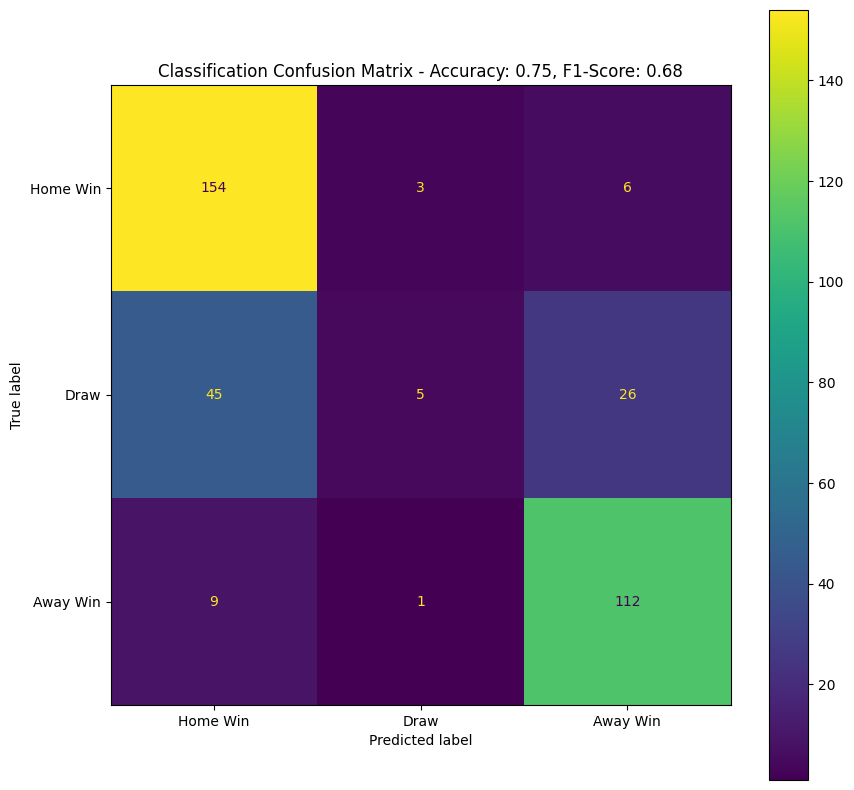

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay



def eval_model(model, test_data, test_labels, is_random_guess=False):
    # Make predictions
    if is_random_guess:
        test_predictions = model.predict(test_data.to_numpy())
    else:
        test_predictions = model.predict(test_data)

    # Classification evaluation
    cm = confusion_matrix(test_labels, test_predictions)
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')

    # Print classification report
    print(classification_report(test_labels, test_predictions, target_names=['Home Win', 'Draw', 'Away Win']))

    # Plot classification confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cm_display = ConfusionMatrixDisplay(cm, display_labels=['Home Win', 'Draw', 'Away Win'])
    cm_display.plot(ax=ax)
    plt.title(f"Classification Confusion Matrix - Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}")
    plt.show()

# Evaluate the Random Forest model on validation and test data
print("Evaluating Random Forest model on validation data...hi")
eval_model(rf_model, transformed_val_data, val_labels)




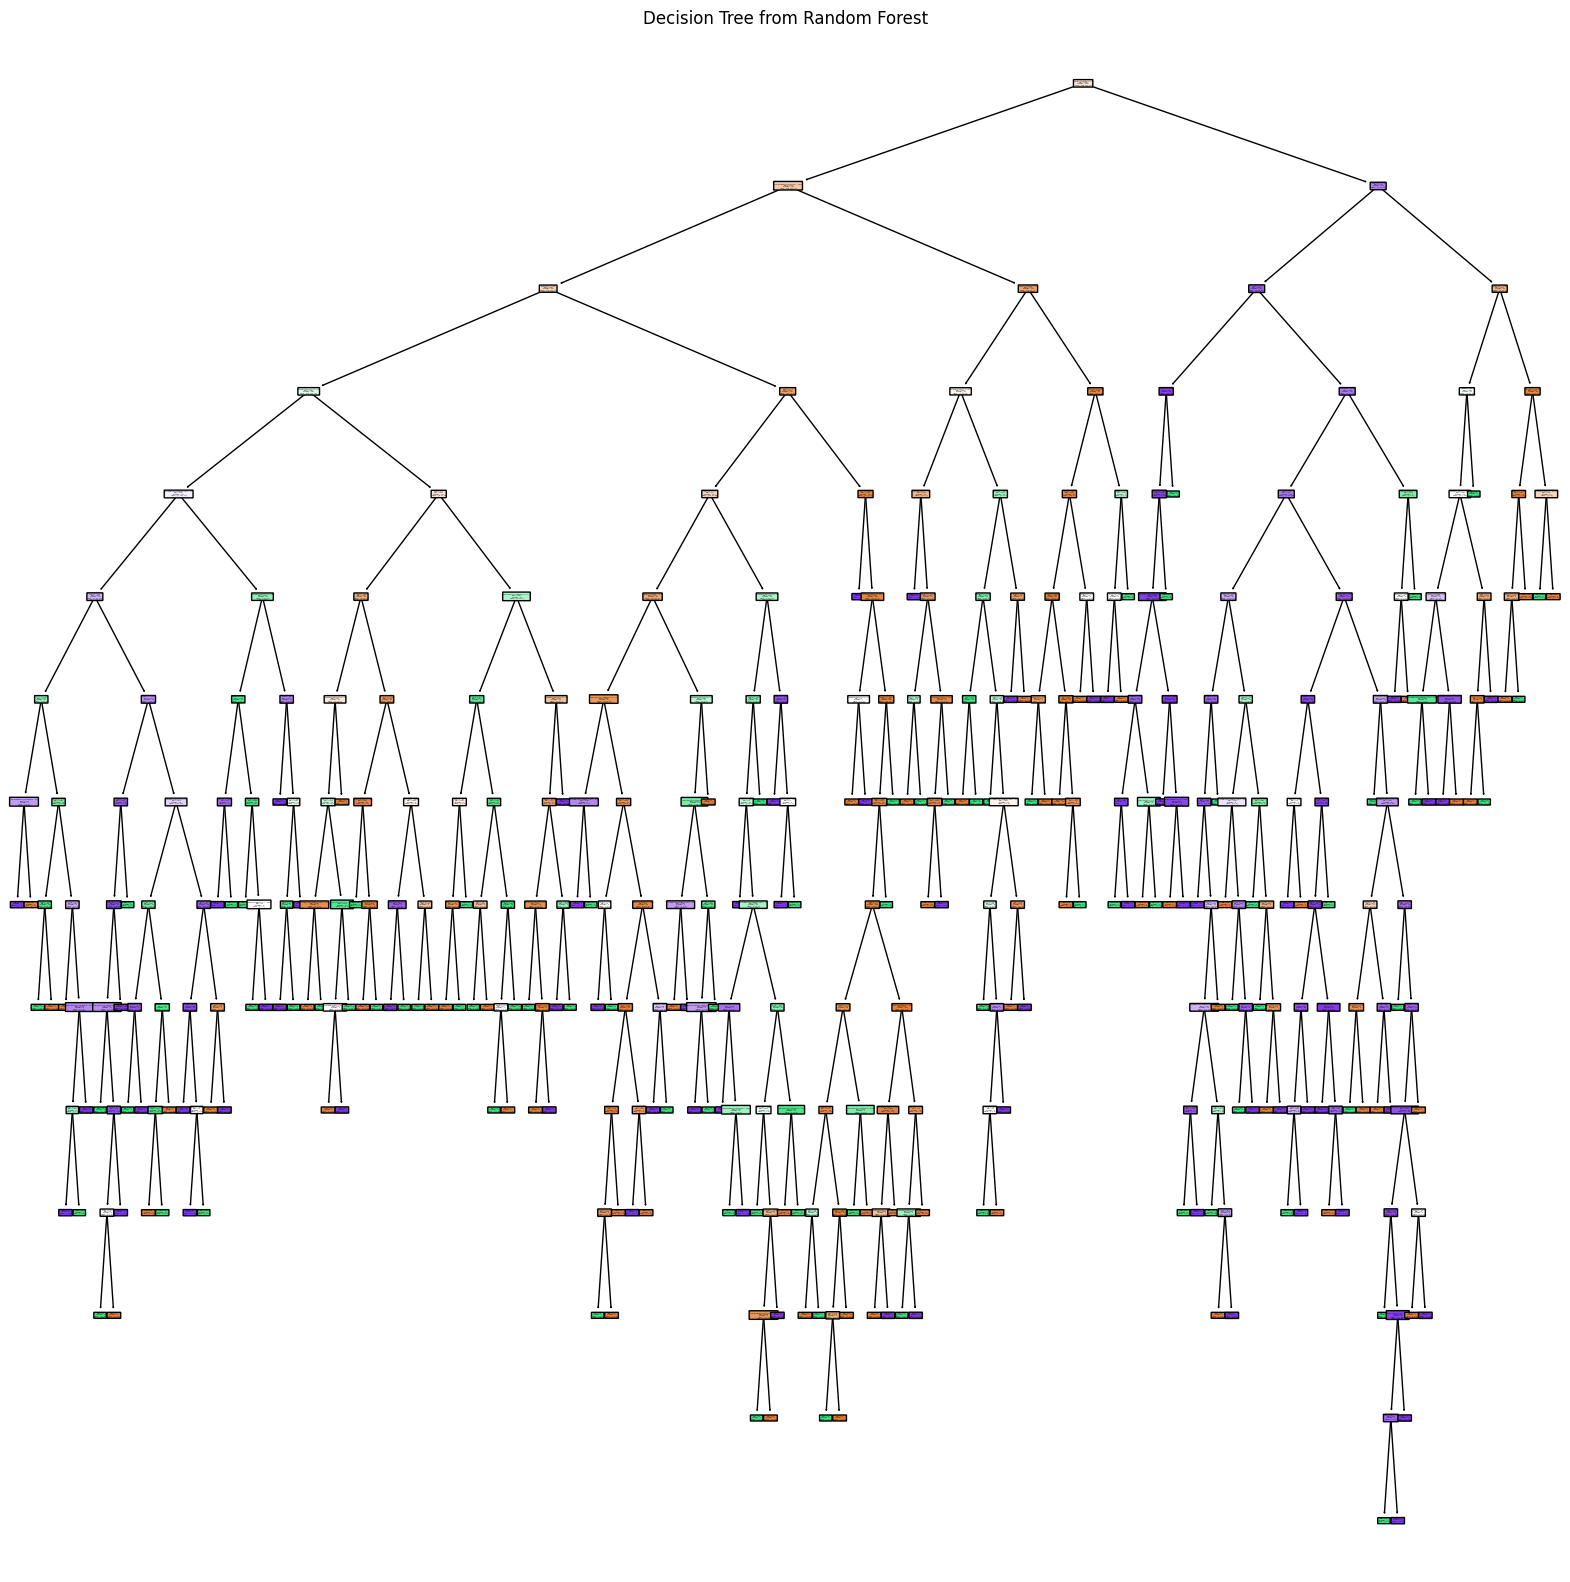

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

tree_index = 0  # You can change this index to plot a different tree

# Ensure your figure is large enough to see the tree details
plt.figure(figsize=(20,20))

# Plot the decision tree
plot_tree(rf_model.estimators_[tree_index],
          filled=True,
          rounded=True,
          class_names=['Home Win', 'Draw', 'Away Win'],
          feature_names=train_data.columns)

# Show the plot
plt.title("Decision Tree from Random Forest")
plt.show()

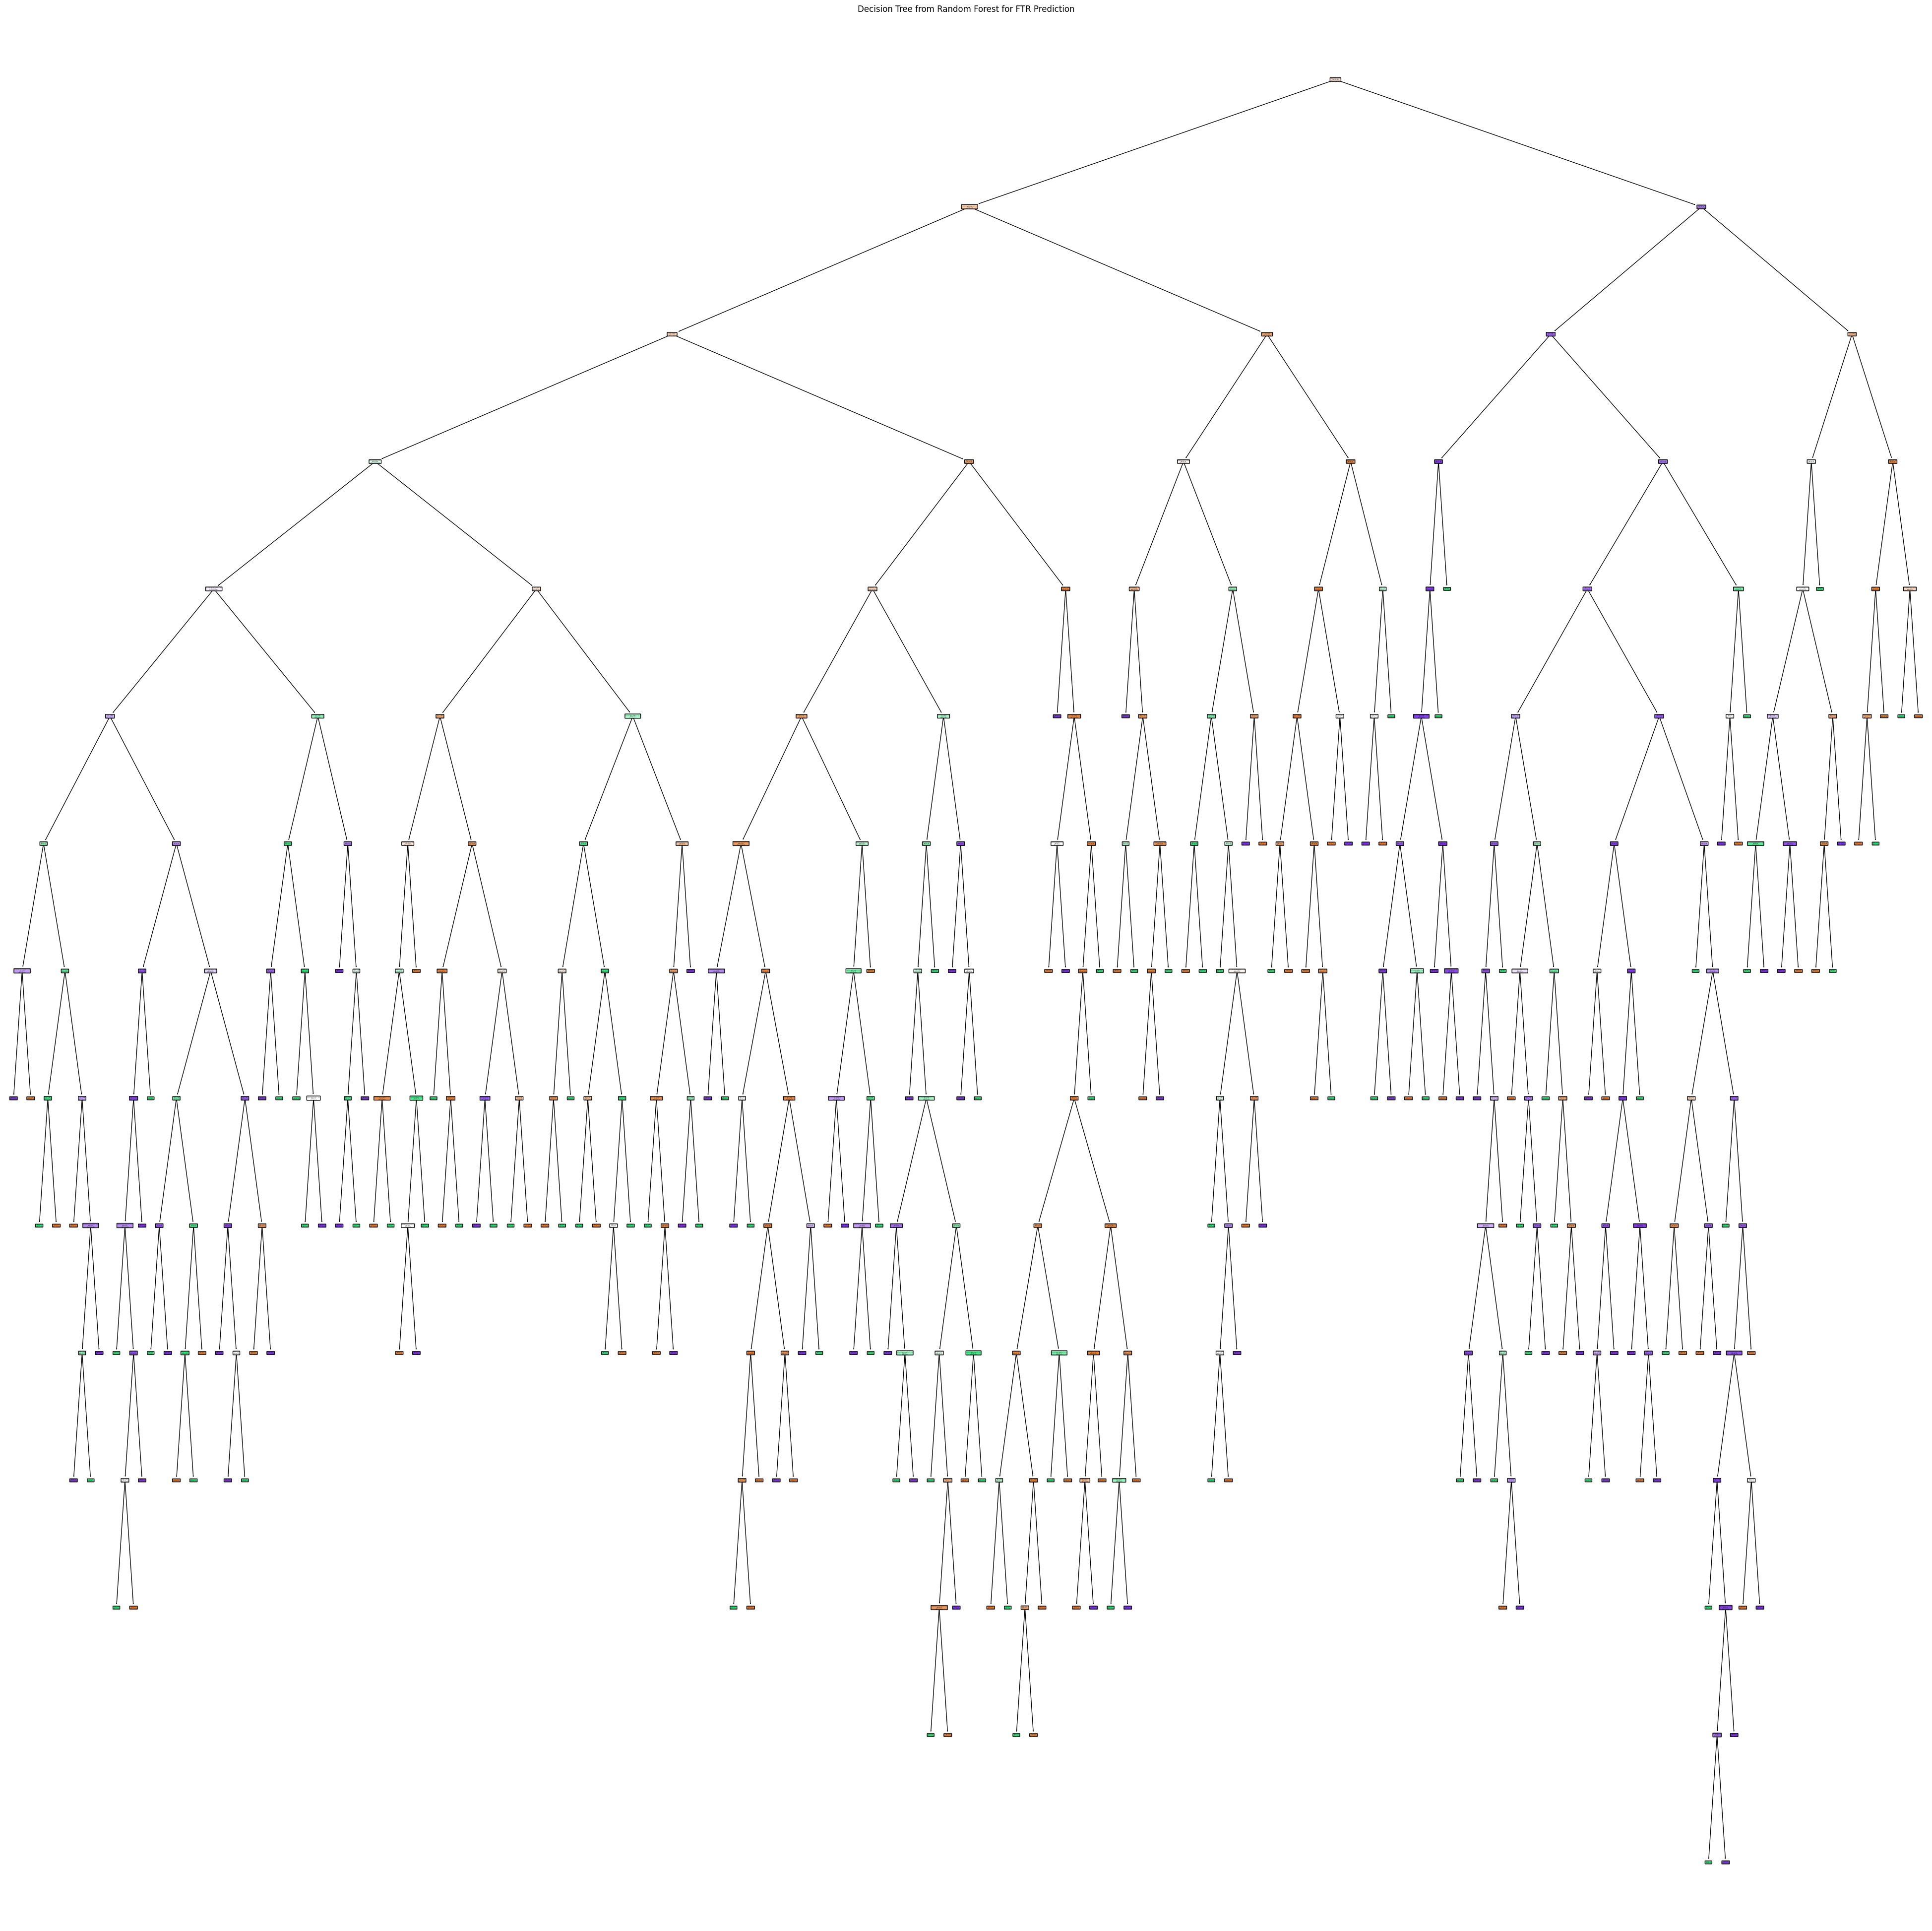

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming you have already loaded and prepared your data
# Here's a reminder to ensure the correct loading and preprocessing of your data:
# train_data = pd.read_csv('path_to_your_train_data.csv')
# train_labels = train_data['FTR']  # Assuming 'FTR' column holds the Full Time Result labels
# train_data = train_data.drop(columns=['FTR'])  # Make sure to remove the label column from the training data set

# Initialize and train your Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(train_data, train_labels)

tree_index = 0  # You can change this index to plot a different tree from the Random Forest ensemble

# Ensure your figure is large enough to see the tree details clearly
plt.figure(figsize=(50,50))

# Plot the decision tree
plot_tree(rf_model.estimators_[tree_index],
          filled=True,
          rounded=True,
          class_names=['Home Win', 'Draw', 'Away Win'],  # This should correspond to the class labels used in 'FTR'
          feature_names=train_data.columns)

# Show the plot
plt.title("Decision Tree from Random Forest for FTR Prediction")
plt.show()